<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-2-этапу" data-toc-modified-id="Выводы-по-2-этапу-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы по 2 этапу</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

# Forecasting taxi orders

Компания по предоставлению услуг такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.
________________________________________________________________________________________________________________________________
A taxi company has collected historical data on taxi bookings at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric on the test set should not exceed 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.

## Подготовка

## Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from itertools import product
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
#data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data = data.resample('1H').sum()

Данные готовы для дальнейшего анализа.

The data is ready for further analysis.

## Анализ

## Analysis

In [5]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [6]:
data['2018-07':'2018-08'].describe()

,num_orders
count,1488.000000
mean,113.829301
std,49.650931
min,11.000000
25%,81.000000
50%,108.000000
75%,140.000000
max,462.000000


In [7]:
data['2018-08':'2018-09'].describe()

,num_orders
count,744.000000
mean,127.651882
std,56.242228
min,13.000000
25%,91.000000
50%,122.000000
75%,160.000000
max,462.000000


In [8]:
data['2018-03':'2018-04'].describe()

,num_orders
count,1464.000000
mean,60.592213
std,30.955170
min,0.000000
25%,41.000000
50%,58.000000
75%,78.000000
max,253.000000


In [9]:
data['2018-05':'2018-06'].describe()

,num_orders
count,1464.000000
mean,78.364754
std,34.191524
min,2.000000
25%,57.000000
50%,76.000000
75%,98.250000
max,234.000000


Рассматриваемый временной ряд не является стационарным, так как с течением времени у него меняется среднее значение и стандартное отклонение.

The time series under consideration is not stationary, since its mean value and standard deviation change over time.

<AxesSubplot:xlabel='datetime'>

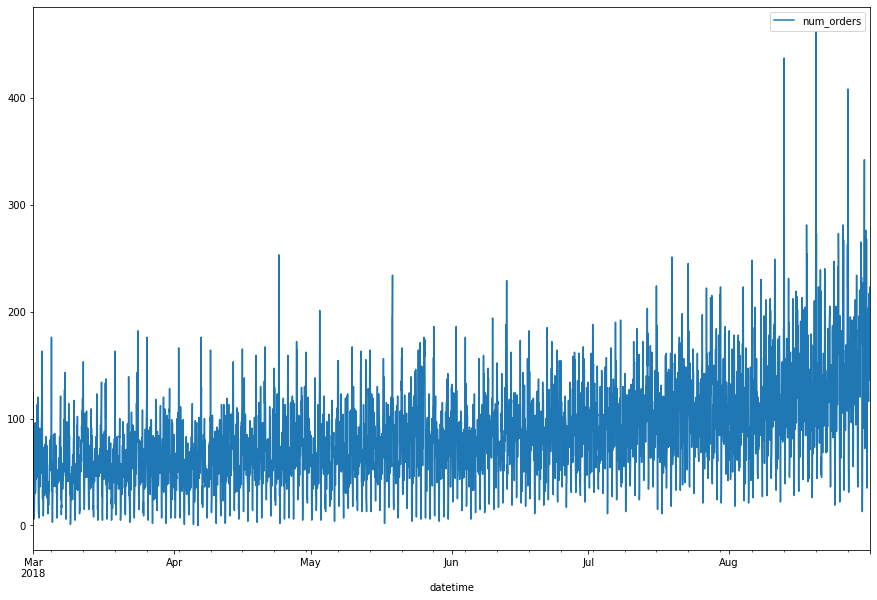

In [10]:
data.plot(figsize=(15, 10))

Рассмотрим данные за последний месяц.

Consider the data for the last month.

In [11]:
data.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

<AxesSubplot:xlabel='datetime'>

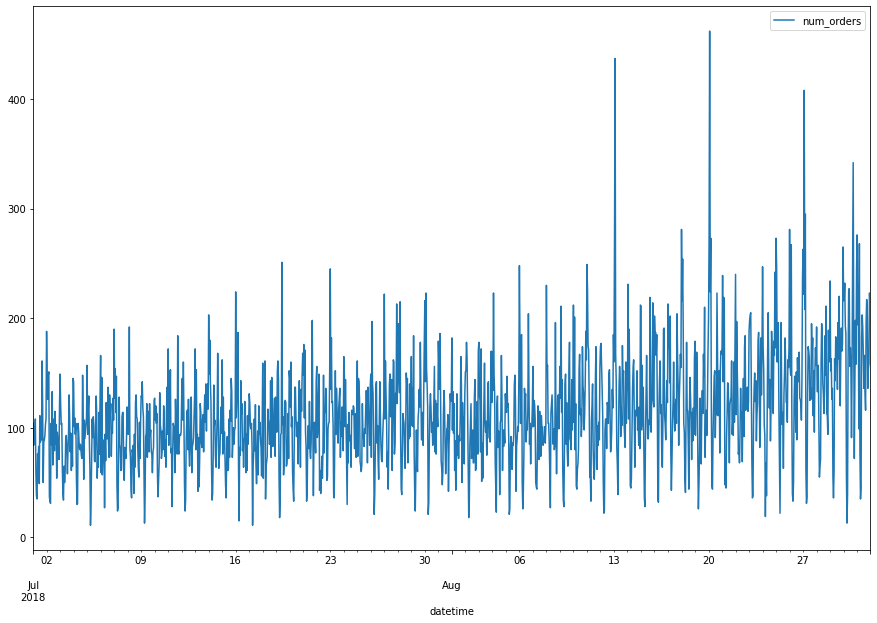

In [12]:
data['2018-07':'2018-08'].plot(figsize=(15, 10))

Проанализируем тренды и сезонность.

Let's analyze trends and seasonality.

<AxesSubplot:xlabel='datetime'>

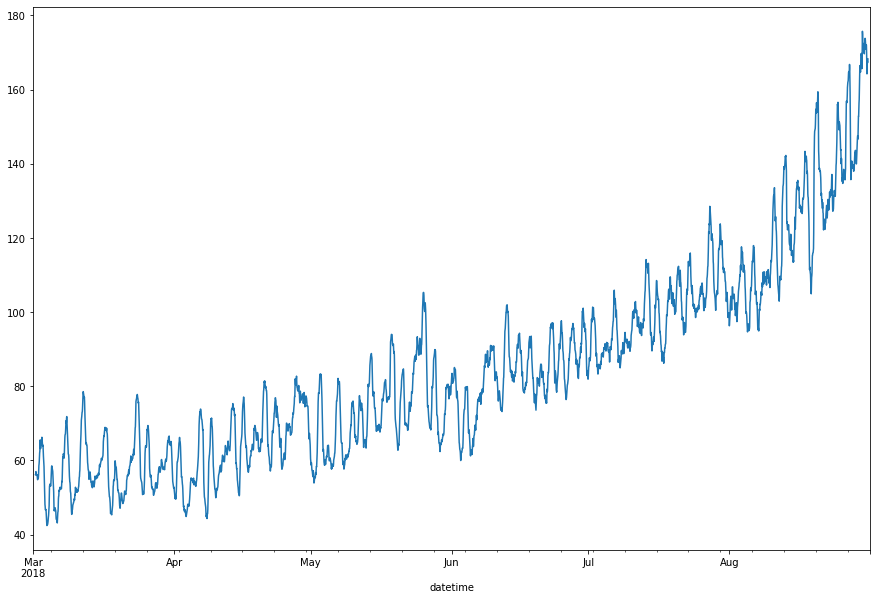

In [13]:
figsize=(15, 10)

data_decomposed = seasonal_decompose(data)

data_decomposed.trend.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

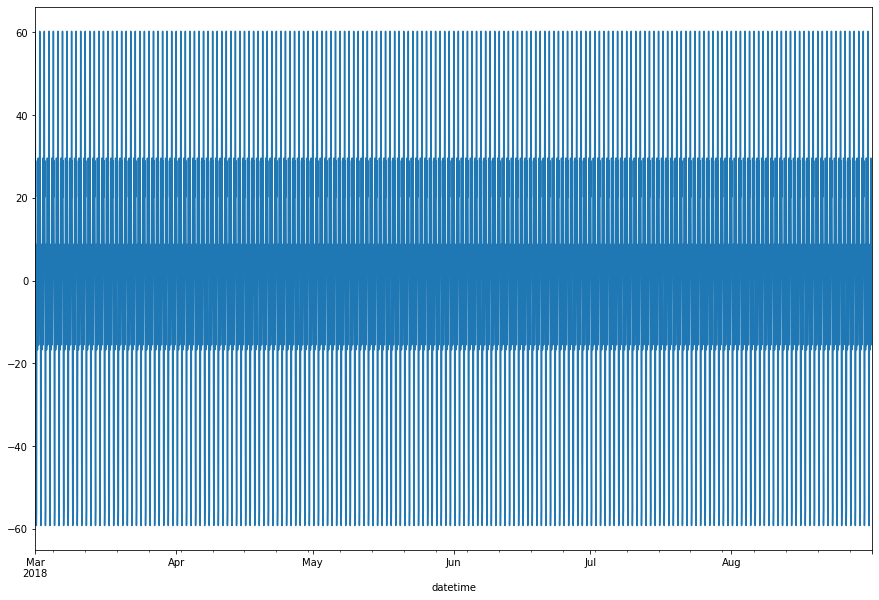

In [14]:
data_decomposed.seasonal.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

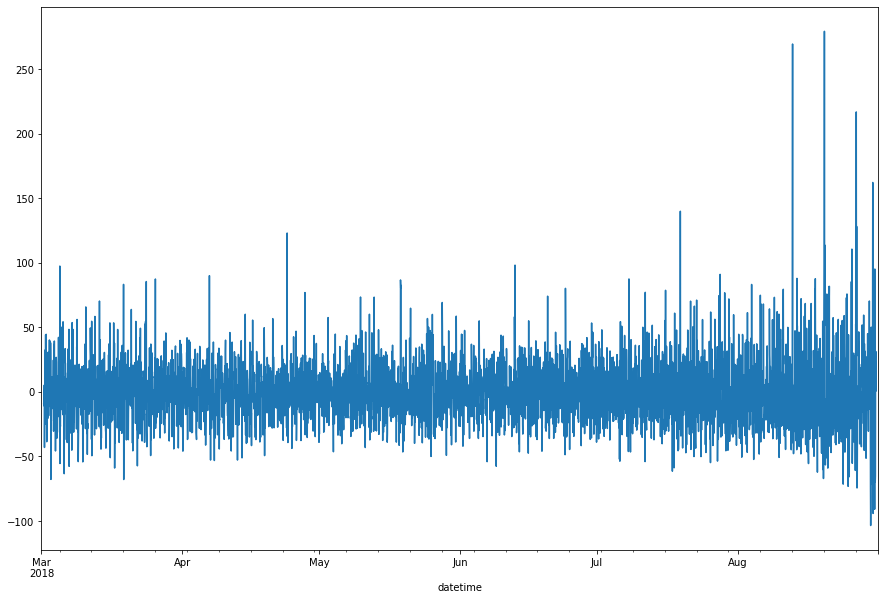

In [15]:
data_decomposed.resid.plot(figsize=figsize)

Теперь проанализируем тренды и сезонность данных за последнюю неделю.

Now let's analyze the trends and seasonality of the data for the last week.

<AxesSubplot:xlabel='datetime'>

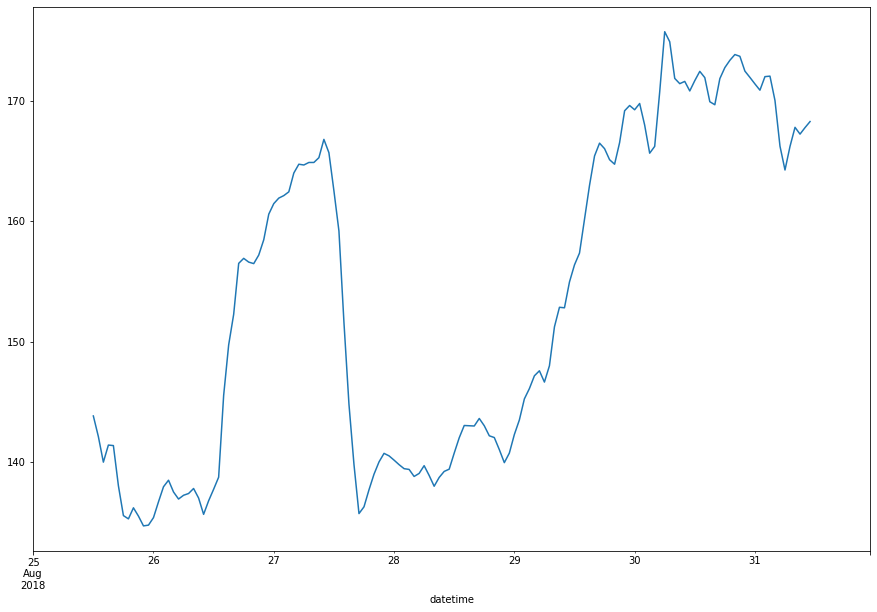

In [16]:
data_decomposed_week = seasonal_decompose(data['2018-08-25':'2018-08-31'])

data_decomposed_week.trend.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

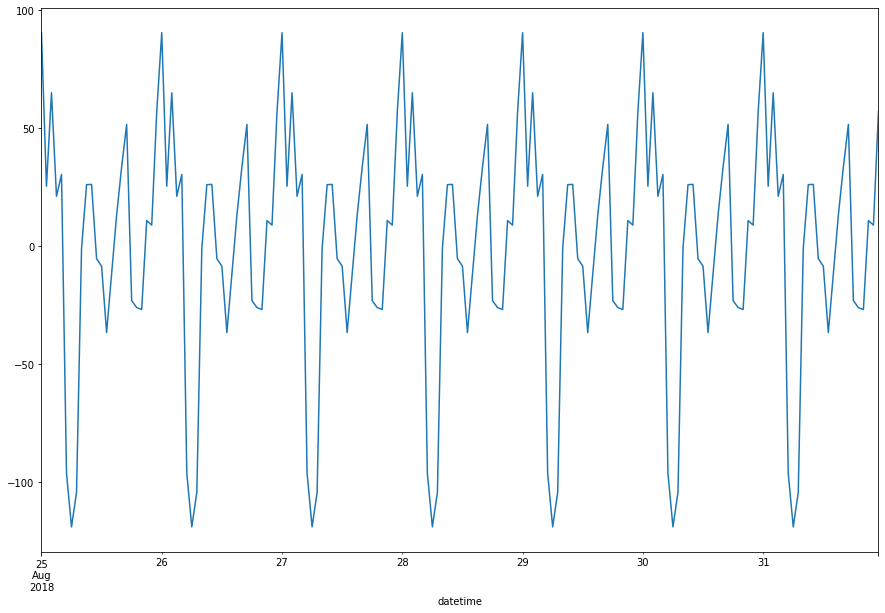

In [17]:
data_decomposed_week.seasonal.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

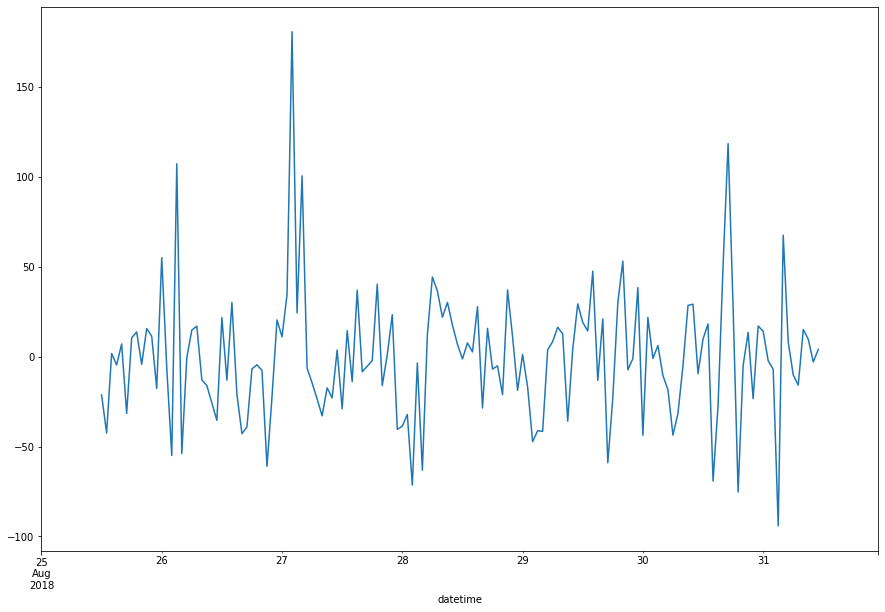

In [18]:
data_decomposed_week.resid.plot(figsize=figsize)

Проанализируем динамику за день.

Let's analyze the dynamics for the day.

<AxesSubplot:xlabel='datetime'>

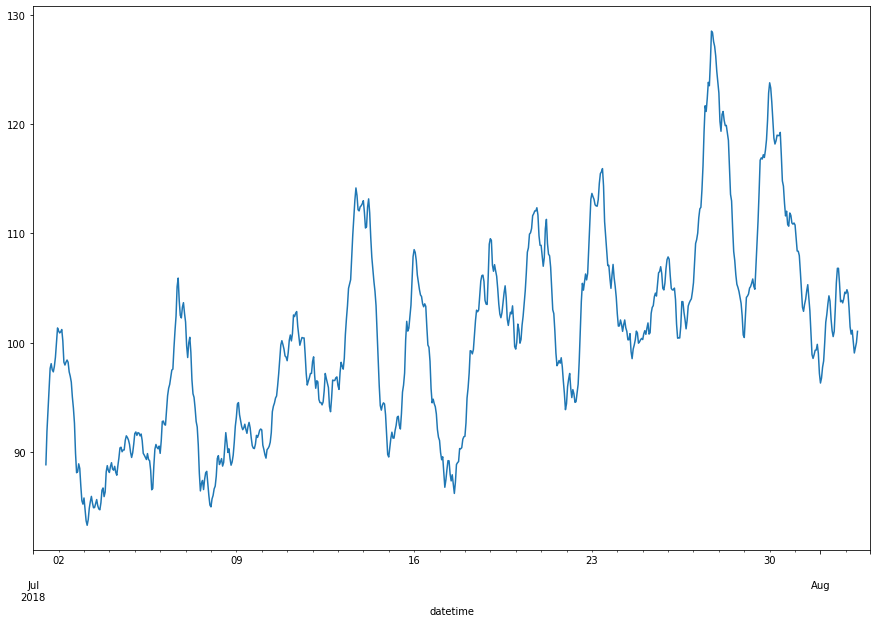

In [19]:
data_decomposed_day = seasonal_decompose(data['2018-07-01':'2018-08-02'])

data_decomposed_day.trend.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

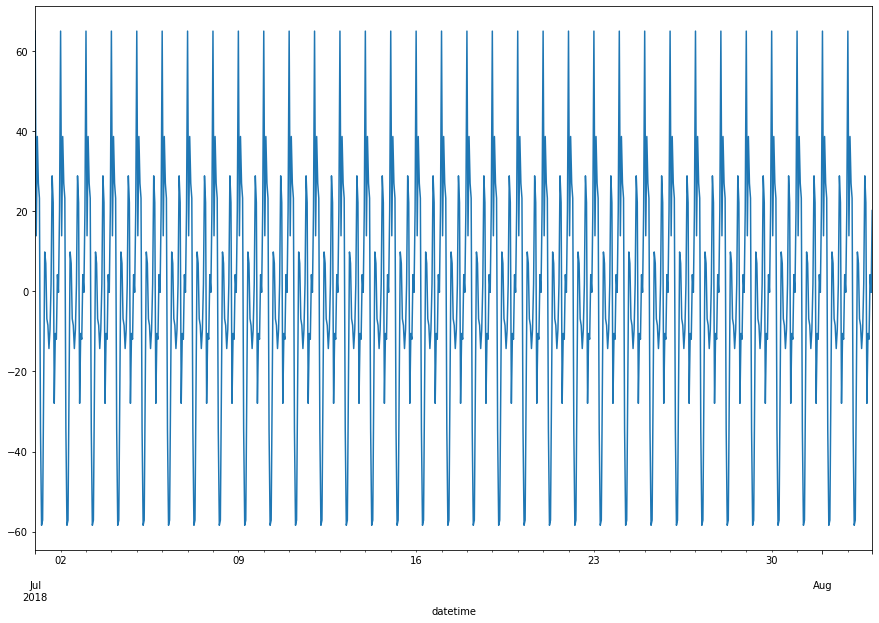

In [20]:
data_decomposed_day.seasonal.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

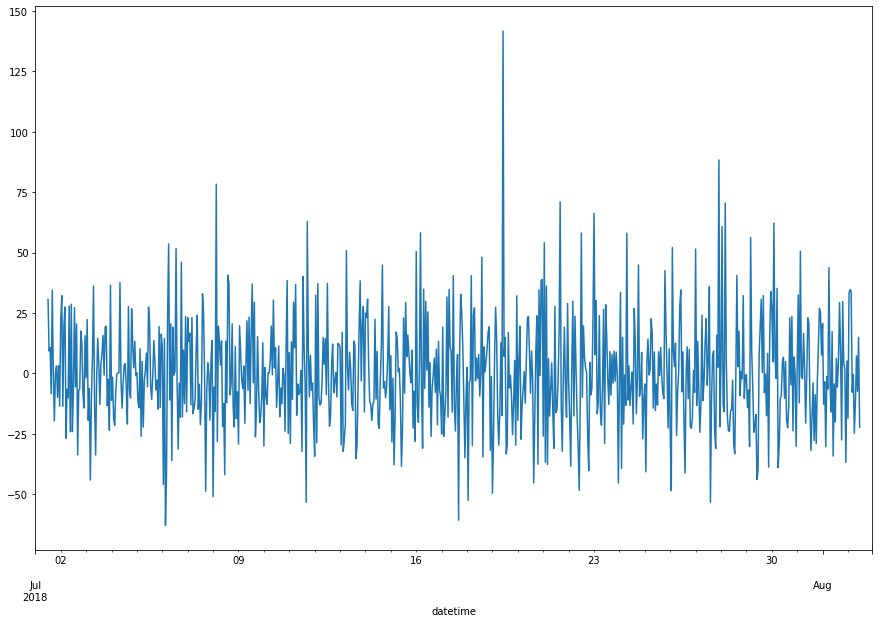

In [21]:
data_decomposed_day.resid.plot(figsize=figsize)

### Выводы по 2 этапу

### Conclusions on stage 2

- Рассматриваемый временной ряд не является стационарным, так как с течением времени у него меняется среднее значение и стандартное отклонение, это также подтверждается наличием явного тренда.
- Тренд показывает постепенное увеличение спроса на услуги такси
- Изучение динамики заказов за день показывает, что существует подъем спроса в ночные часы, а также изменения спроса в течение недели.
________________________________________________________________________________________________________________________________
- The considered time series is not stationary, since over time its mean value and standard deviation change, this is also confirmed by the presence of a clear trend.
- The trend shows a gradual increase in demand for taxi services
- Studying the dynamics of orders over the day shows that there is a rise in demand at night, as well as changes in demand during the week.

## Обучение

## Education

Начнем с функции для подготовки признаков для обучения моделей, выбранных по итогам предыдущего анализа.

Let's start with a function for preparing features for training models selected from the previous analysis.

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Теперь разобьем данные на выборки.

Now let's split the data into samples.

In [23]:
make_features(data, 1, 24)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
 
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Присутпим к обучению моделей. Выберем для сравнения три типа:

- LinearRegression
- DecisionTreeRegressor
- CatBoostRegressor

Начнем с линейной регрессии.
________________________________________________________________________________________________________________________________
Let's take a look at model training. Let's choose three types for comparison:

-LinearRegression
-DecisionTreeRegressor
- Cat Boost Regressor

Let's start with linear regression.

In [24]:
%%time

model_LR = LinearRegression()
print('# Train for root_mean_squared_error')
print()
RMSE_LR = (cross_val_score(model_LR, 
                           features_train, 
                           target_train, 
                       #    cv=5, 
                           cv = TimeSeriesSplit(n_splits=8),
                           scoring='neg_root_mean_squared_error').mean() * -1)
print('Mean RMSE from CV of LinearRegression =', RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 31.366763577025026
CPU times: user 41 ms, sys: 3.63 ms, total: 44.7 ms
Wall time: 42.3 ms


Далее рассмотрим DecisionTreeRegressor.

Next, consider the DecisionTreeRegressor.

In [ ]:
%%time

best_params = None
best_result = 0

for params in tqdm(itertools.product(range(1, 40), range(1, 15), range(1, 10))):
    depth, min_s_1, samples_split = params
    model = DecisionTreeRegressor(random_state=161222, max_depth = depth, 
                                    min_samples_leaf = min_s_1, min_samples_split=samples_split/10)
    model.fit(features_train, target_train)
    
        
print(f'RMSE of the best model {np.round(best_result, 5)}')
print(f'\nParams:\nmax_depth = {best_params[0]}\nmin_samples_leaf = {best_params[2]}\nmin_samples_split = {best_params[3]}')

Теперь рассмотрим работу регрессора CatBoostRegressor.

Now let's look at the work of the CatBoostRegressor regressor.

In [27]:
%%time

cat_model = CatBoostRegressor(random_state = 161222, verbose = False)
parametrs = {'depth' : range(1, 5, 1),
            'iterations' : range(100, 500, 100)
               }
t_cv=TimeSeriesSplit(n_splits=8).split(features_train)
grid = GridSearchCV(cat_model, parametrs, cv=t_cv, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)

print("Best parameters set found on development set:")
print()
best_params_CBR = grid.best_params_
print(best_params_CBR)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Best parameters set found on development set:

{'depth': 4, 'iterations': 400}

Grid scores on development set:

5.211901 for {'depth': 1, 'iterations': 100}
5.196871 for {'depth': 1, 'iterations': 200}
5.197099 for {'depth': 1, 'iterations': 300}
5.191367 for {'depth': 1, 'iterations': 400}
5.029681 for {'depth': 2, 'iterations': 100}
5.013205 for {'depth': 2, 'iterations': 200}
5.011454 for {'depth': 2, 'iterations': 300}
5.007277 for {'depth': 2, 'iterations': 400}
4.974116 for {'depth': 3, 'iterations': 100}
4.966820 for {'depth': 3, 'iterations': 200}
4.966979 for {'depth': 3, 'iterations': 300}
4.975896 for {'depth': 3, 'iterations': 400}
4.966191 for {'depth': 4, 'iterations': 100}
4.956331 for {'depth': 4, 'iterations': 200}
4.957885 for {'depth': 4, 'iterations': 300}
4.950895 for {'depth': 4, 'iterations': 400}

CPU times: user 12.5 s, sys: 2.2 s, total: 14.7 s
Wall time: 1min 49s


## Тестирование

## Testing

На данном этапе проверим лучшую модель на тестовой выборке.

At this stage, we will check the best model on the test set.

Learning rate set to 0.107144
0:	learn: 37.2000818	total: 739us	remaining: 295ms
1:	learn: 35.5507264	total: 1.42ms	remaining: 283ms
2:	learn: 34.0905588	total: 2.08ms	remaining: 275ms
3:	learn: 33.1533651	total: 2.76ms	remaining: 273ms
4:	learn: 32.2396255	total: 3.42ms	remaining: 270ms
5:	learn: 31.5892620	total: 4.09ms	remaining: 268ms
6:	learn: 30.9178792	total: 4.69ms	remaining: 264ms
7:	learn: 30.4683493	total: 5.34ms	remaining: 262ms
8:	learn: 29.6525011	total: 5.99ms	remaining: 260ms
9:	learn: 29.0809803	total: 6.62ms	remaining: 258ms
10:	learn: 28.6775415	total: 7.29ms	remaining: 258ms
11:	learn: 28.2479242	total: 7.95ms	remaining: 257ms
12:	learn: 27.9209252	total: 8.52ms	remaining: 254ms
13:	learn: 27.6557138	total: 9.11ms	remaining: 251ms
14:	learn: 27.4147917	total: 9.65ms	remaining: 248ms
15:	learn: 27.0077890	total: 10.3ms	remaining: 247ms
16:	learn: 26.7867320	total: 10.9ms	remaining: 245ms
17:	learn: 26.6103416	total: 11.5ms	remaining: 245ms
18:	learn: 26.3498353	total

46.20850636964734

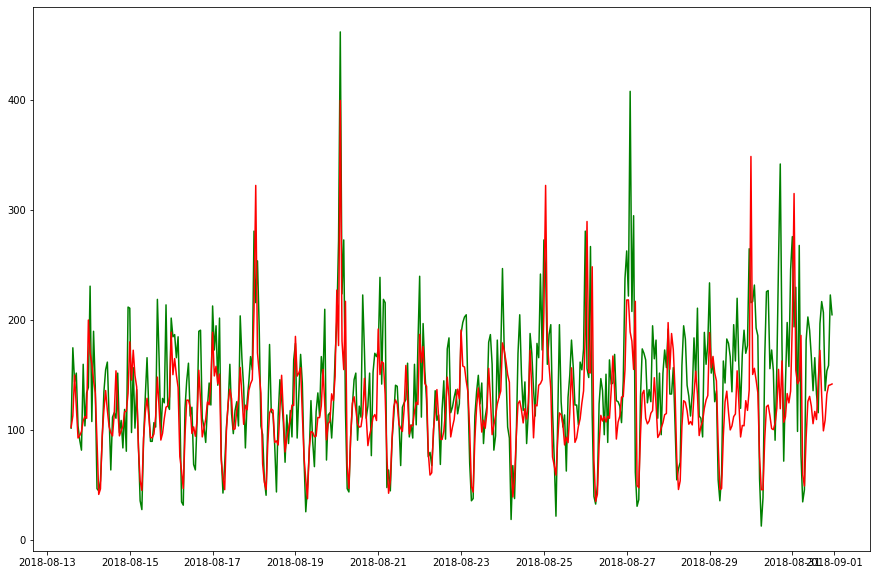

In [28]:
%%time

cat_model = CatBoostRegressor()
cat_model.set_params(**best_params_CBR)
cat_model.fit(features_train, target_train)
target_predict = cat_model.predict(features_test)
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'g-', 
         target_test.index, 
         target_predict,
         'r-')

final_RMSE_CBR

In [29]:
%%time

pred_valid = cat_model.predict(features_test) 

CPU times: user 1.81 ms, sys: 164 µs, total: 1.97 ms
Wall time: 1.2 ms


In [30]:
mean_squared_error(target_test, pred_valid) ** 0.5

46.20850636964734

## Итоги

## Results

В ходе работы было выполнено:

1. Загружены данные и проведен их анализ (выявлены тренды, сезонность, определено, что ряд не стационарный).
2. Выполнено сравнение трех выбранных моделей.
3. Выбрана лучшая модель по результатам метрики RMSE.

Наилучшей моделью для решения данной задачи по итогам является CatBoostRegressor с показателем RMSE = 18.7, временем обучения 1.04 s и временем предсказания 1.57 ms.
________________________________________________________________________________________________________________________________

In the course of the work, the following was done:

1. The data was loaded and analyzed (trends, seasonality were identified, it was determined that the series is not stationary).
2. Three selected models were compared.
3. The best model was selected according to the results of the RMSE metric.

Based on the results, the best model for solving this problem is CatBoostRegressor with RMSE = 18.7, training time 1.04 s and prediction time 1.57 ms.